In [1]:
import sys
sys.path.append('../../30_data_tools/')

In [5]:
from get_labelstudio_data import get_results_of_project
from helper import load_dotenv

In [7]:
import pandas as pd
import sqlite3
import plotly.express as px

In [6]:
dotenv = load_dotenv()

In [10]:
con = sqlite3.connect( dotenv['DB_PATH'] )

In [25]:
masks = pd.read_sql(
    '''
        SELECT gi."timestamp", m.* FROM mask m 
        LEFT JOIN generic_image gi 
        ON
            m.pdf_filename = gi.pdf_filename AND 
            m.job = gi.job AND 
            m."type" = gi."type" AND 
            m.variant_name = gi.variant_name AND 
            m."method" = gi."method" AND 
            m.idx = gi.idx 
        ORDER BY gi."timestamp" DESC
    ''',
    con,
    parse_dates=['timestamp']
)

masks = pd.merge(
    masks,
    pd.DataFrame(
        [(r['id'],r['rectanglelabels'][0]) for r in get_results_of_project(2) if 'id' in r],
        columns=['mask_id','mask_label']
    ),
    how="left",
    on="mask_id"
)
masks = masks.loc[pd.isna(masks.mask_label) == False]

In [41]:
grouped = masks.loc[
    :,
    ['timestamp','mask_label','job']
].groupby([
    pd.Grouper(key='timestamp', freq="d"),
    'mask_label'
]).count().unstack('mask_label')

grouped.columns = [c[1] for c in grouped.columns]
grouped.loc[
    :,
    'moire_ratio'
] = grouped.checked_moire / (grouped.checked_moire + grouped.checked_no_moire)

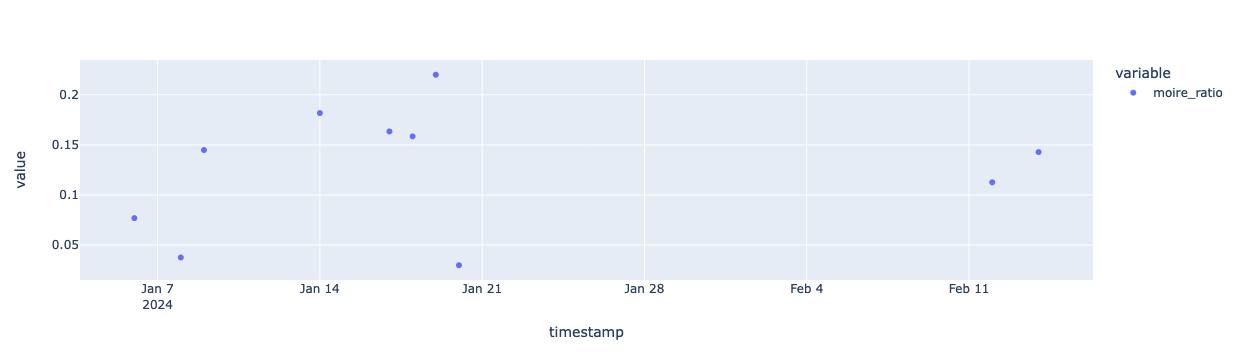

In [45]:
px.scatter(
    grouped.moire_ratio
)